Based on code by Tucker Hartland in linear_inversion3D_cylinder.py

In [1]:
from linear_inversion3D_cylinder import *

In [2]:
dl.set_log_active(False)
ndim = 3

linear        = True # linear or nonlinear forward model 
compression   = False # generate compressions of the Hessian misfit
hodlr         = False
verbose_save  = False
solve_inverse = False # do you want to determine the MAP point or not?
inexact       = True
direc         = './figures/'
if compression and hodlr:
    compression_type = "HODLR"
elif compression and not hodlr:
    compression_type = "LR"
else:
    compression_type = ""

# Reduce order of quadrature
dl.parameters['form_compiler']['quadrature_degree'] = 4

# forcing term
grav = 9.81
rho = 910.0

Length = 1.
Width  = 1.
Height = 1.
# rheology
if linear:
    n = 1
    A_value = 2.140373e-7
else:
    n = 3.0
    A_value = 1.e-16 
A = dl.Constant(A_value)

# Mesh

In [3]:
# boundary and submesh needed for manifold prior
# IMPORTANT ========
mfile_name = "meshes/cylinder_coarse"
# ==================
mesh = dl.Mesh(mfile_name+".xml")
boundary_markers = dl.MeshFunction("size_t", mesh, mfile_name+"_facet_region.xml")
boundary_mesh = dl.BoundaryMesh(mesh, "exterior", True)
submesh_bottom = dl.SubMesh(boundary_mesh, BasalSub())

mesh

# Mesh manipulation

In [4]:
r0            = 0.05
sig           = 0.4
valleys       = 4
valley_depth  = 0.35
bump_height   = 0.2
min_thickness = 0.08 / 8.
avg_thickness = 0.2 / 8.
theta         = -np.pi/2.
max_thickness = avg_thickness + (avg_thickness - min_thickness) 
A_thickness   = max_thickness - avg_thickness


dilitation = 1.e4
Length *= 2*dilitation
Width  *= 2*dilitation
Radius  = dilitation

coords   = mesh.coordinates()
bcoords  = boundary_mesh.coordinates()
subbcoords = submesh_bottom.coordinates()
coord_sets = [coords, bcoords, subbcoords]
   
def topography(r, t):
    zero = np.zeros(r.shape)
    R0   = r0*np.ones(r.shape)
    return bump_height*np.exp(-(r/sig)**2)*(1.+valley_depth*np.sin(valleys*t-theta)*np.fmax(zero, (r-R0)/sig))

def depth(r, t):
     zero = np.zeros(r.shape)
     R0   = r0*np.ones(r.shape)
     return min_thickness - A_thickness*np.sin(valleys*t-theta)*np.exp(-(r/sig)**2)*np.fmax(zero, (r-R0)/sig)

# note that in order to have nonuniform thickness
# depth will no longer be constant but a function
# of (x,y) 
for k in range(len(coord_sets)): 
    for i in range(len(coord_sets[k])):
        x,y,z = coord_sets[k][i]
        r     = np.sqrt(x**2+y**2)
        t     = np.arctan2(y, x)
        coord_sets[k][i,2] = depth(r,t)*z + topography(r,t)
        coord_sets[k][i] *= dilitation
        
mesh

In [5]:
    rank = dl.MPI.rank(mesh.mpi_comm())
    nproc = dl.MPI.size(mesh.mpi_comm())
    
    P1  = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    P2  = dl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    TH = P2 * P1
    Vh2 = dl.FunctionSpace(mesh, TH)
    Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vsub = dl.FunctionSpace(submesh_bottom, 'Lagrange', 1)
    Vh = [Vh2, Vh1, Vh2]
    
    ndofs = [Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim()]
    if rank == 0:
        print ("Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs))

Number of dofs: STATE=40413, PARAMETER=1830, ADJOINT=40413


# SET UP FORWARD MODEL

In [6]:
# Forcing term
f=dl.Constant( ( 0.0, 0.0, -rho*grav) )

# Dirichlet condition.
bc  = []
bc0 = []

# Base Sliding boundary marker
ds = dl.Measure("ds", domain=mesh, subdomain_data=boundary_markers)

normal = dl.FacetNormal(mesh)

# penalty parameter
if linear:
    lam = 1.e14 #1.e18
else:
    lam = 1.e14
# Define the Nonlinear stoke varfs
nonlinearStokesFunctional = NonlinearStokesForm(n, A, normal, ds(1), f, lam)

# Create one-hot vector on pressure dofs
constraint_vec = dl.interpolate( dl.Constant((0,0,0,1)), Vh[hp.STATE]).vector()

pde = EnergyFunctionalPDEVariationalProblem(Vh, nonlinearStokesFunctional, constraint_vec, bc, bc0)
pde.fwd_solver.parameters["rel_tolerance"] = 1.e-8
pde.fwd_solver.parameters["print_level"] = 1
pde.fwd_solver.parameters["LS"]["max_backtracking_iter"] = 10
pde.fwd_solver.solver = dl.PETScLUSolver(method="mumps")

# SET UP PRIOR DISTRIBUTION
Recall from Daon Stadler 2017: The covariance function of the free-space operator has a characteristic length of
$$\sqrt(8(p - d / 2)) \sqrt( \gamma/\delta )$$
meaning that that distance away from a source $x$, the covariance decays to $0.1$ of its maximal value
 - d - dimension of problem
 - A^(-p) - operator, A laplacian-like

In [7]:


gamma=6.e2
rel_correlation_Length = 0.1
correlation_Length = Length*rel_correlation_Length

delta = 4.*gamma/(correlation_Length**2)

m_val1 = 1.e2
m_val2 = 1.e4
prior_mean_val = np.log((m_val1 + m_val2)/2.)

prior_mean = dl.interpolate(dl.Constant(prior_mean_val), Vsub).vector()
priorVsub  = hp.BiLaplacianPrior(Vsub, gamma, delta, mean=prior_mean, robin_bc=False)
prior      = ManifoldPrior(Vh[hp.PARAMETER], Vsub, boundary_mesh, priorVsub)
#Bmatrix = hp.Permutation_matrix(Vh[hp.PARAMETER], Vsub, boundary_mesh,\
#                  save=True,direc="./figures/")
#permut_mat = Bmatrix.kdorderedmatrix([0, 1])
projector_mat = hp.Projector(Vh[hp.PARAMETER], Vsub, boundary_mesh)

# SET UP DATA FIDELITY TERM

Text(0.5, 1.0, 'observation locations')

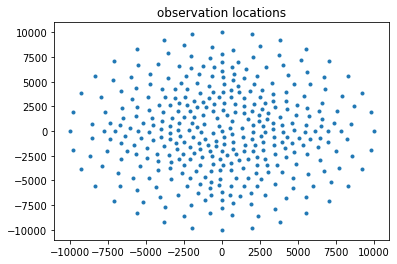

In [8]:
# ntargets equally distributed observation points close to the top boundary
ntargets = len(subbcoords)
targets = np.zeros((ntargets,  ndim), dtype = np.float64)
Xtargets = subbcoords[:ntargets, 0]
Ytargets = subbcoords[:ntargets, 1]

targets[:,:2] = np.array([Xtargets.flatten(), Ytargets.flatten()]).T
for i in range(ntargets):
    x = targets[i, 0] 
    y = targets[i, 1]
    r = np.sqrt(x**2+y**2)/dilitation
    t = np.arctan2(y, x)
    targets[i, 2] = dilitation*(depth(r,t)*0.999999 + topography(r,t))
    
plt.scatter(targets[:,0], targets[:,1], marker='.')
# plt.scatter(targets[:,0], targets[:,1], c=targets[:,2], marker='.')
# plt.scatter(targets[:,0], targets[:,1], c=np.sin(1e-8*targets[:,0]), marker='.')
plt.title('observation locations')

# Define ground truth image basal sliding

In [9]:
m_func = dl.Expression('std::log(m1 + (m2-m1)*(x[0]*x[1] > 0.))',\
                        element=Vh[hp.PARAMETER].ufl_element(),\
                        m1 = m_val1, m2=m_val2)
#m_func = dl.Expression('std::log(m1 + (m2-m1)*'+\
#                        '((x[0]*x[0]+x[1]*x[1])/(R*R)-r*r)*((x[0]*x[0] + x[1]*x[1])/(R*R)> r*r))',\
#                        element=Vh[hp.PARAMETER].ufl_element(),\
#                        m1= m_val1, m2=m_val2, r=0.5, R=dilitation)                        
mtrue = dl.interpolate(m_func, Vh[hp.PARAMETER]).vector()

# Compute the state at ground truth

In [10]:
utrue = pde.generate_state()
pde.solveFwd(utrue, [utrue, mtrue, None])
utrue_field = hp.vector2Function(utrue, Vh[hp.STATE], name="state-truth")
mtrue_field = hp.vector2Function(mtrue, Vh[hp.PARAMETER], name="parameter-truth")
dl.File(direc+'u_true.pvd') << utrue_field.sub(0)
dl.File(direc+'p_true.pvd') << utrue_field.sub(1)
dl.File(direc+'m_true.pvd') << mtrue_field

Solving Nonlinear Problem
Nit          Energy           ||g||          (g,du)           alpha
  0    1.457781e+11    4.272050e+12      -                 -          
  1    -4.082274e+14    4.272050e+12   -8.167464e+14    1.000000e+00
  2    -4.082274e+14    1.017091e+06   -6.533769e+01    1.000000e+00
  3    -4.082274e+14    3.109760e+05   -1.506479e-08    1.250000e-01
  4    -4.082274e+14    3.277989e+05   -1.631597e-08    3.125000e-02
  5    -4.082274e+14    3.411949e+05   -1.632277e-08    1.000000e+00
Maximum number of backtracking reached
Newton did NOT converge in  6 iterations.
Final norm of the gradient:  341194.85788211756
Value of the cost functional:  -408227412067005.94


# Build noisy observations from ground truth

In [11]:
noise_lvl = 0.01
indicator = dl.interpolate( dl.Constant((1,1,0,0)), Vh[hp.STATE])
component_observed = dl.interpolate( dl.Constant((1,1,0,0)), Vh[hp.STATE]).vector()
uh, vh = dl.TrialFunction(Vh[hp.STATE]), dl.TestFunction(Vh[hp.STATE])
misfit_form = dl.inner(indicator, uh)*dl.inner(indicator, vh)*ds(3)
#misfit = hp.ContinuousStateObservation(Vh[hp.STATE], ds(3), bc, form=misfit_form)
misfit = PointwiseProjectedStateObservation(Vh[hp.STATE], targets, component_observed)
misfit.B.mult(utrue, misfit.d)

#misfit.d.set_local(utrue.get_local())
noise_std_dev = misfit.d.norm("linf")*noise_lvl
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev
# ==== Define the model ====
model = hp.Model(pde, prior, misfit)

# Map Point reconstruction

In [14]:
m = prior.mean.copy()
u0 = pde.generate_state()
pde.solveFwd(u0, [u0, m, None])
u0_field = hp.vector2Function(u0, Vh[hp.STATE], name="initial field")
m0_field = hp.vector2Function(m, Vh[hp.PARAMETER], name="initial parameter")

dl.File(direc+'u0.pvd') << u0_field.sub(0)
dl.File(direc+'p0.pvd') << u0_field.sub(1)
dl.File(direc+'m0.pvd') << m0_field

Solving Nonlinear Problem
Nit          Energy           ||g||          (g,du)           alpha
  0    1.457781e+11    4.272050e+12      -                 -          
  1    -3.478161e+14    4.272050e+12   -6.959238e+14    1.000000e+00
Maximum number of backtracking reached
Newton did NOT converge in  2 iterations.
Final norm of the gradient:  4272049623223.9907
Value of the cost functional:  -347816135882364.06


In [17]:
parameters = hp.ReducedSpaceNewtonCG_ParameterList()
parameters["print_level"] = 1 
parameters["rel_tolerance"] = 1e-8
parameters["abs_tolerance"] = 1e-12
parameters["max_iter"]      = 40
parameters["cg_max_iter"]   = 150
parameters["globalization"] = "LS"
parameters["GN_iter"] = parameters["max_iter"] + 1
parameters["cg_coarse_tolerance"] = 0.5
if inexact:
    parameters["cg_coarse_tolerance"] = 0.5
else:       
    parameters["cg_coarse_tolerance"] = 1.e-12

if rank != 0:
    parameters["print_level"] = -1

print(parameters.showMe())

 ---
 GN_iter (41): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking iterations
     ---
 ---
 TR (ParameterList): Sublist containing TR globalization parameters
     ---
     eta (0.05): Reject step if (actual reduction)/(predicted reduction) < eta
     ---
 ---
 abs_tolerance (1e-12): we converge when sqrt(g,g) <= abs_tolerance
 ---
 cg_coarse_tolerance (0.5): Coarsest tolerance for the CG method (Eisenstat-Walker)
 ---
 cg_max_iter (150): Maximum CG iterations
 ---
 gdm_tolerance (1e-18): we converge when (g,dm) <= gdm_tolerance
 ---
 globalization (LS): Globalization technique: line search (LS)  or trust region (TR)
 ---
 max_iter (40): maximum number of iterations
 ---
 print_level (1): Control verbosity of printing screen
 ---
 rel_tolerance (1e-08): w

In [18]:
if solve_inverse:
    solver = hp.ReducedSpaceNewtonCG(model, parameters)
    x = solver.solve([None, m, None])

    state_reconstruction = hp.vector2Function(x[hp.STATE], Vh[hp.STATE], name="state-reconstruction")
    parameter_reconstruction = hp.vector2Function(x[hp.PARAMETER], Vh[hp.PARAMETER], name="parameter-reconstruction")
    dl.File(direc+"u_reconstruction.pvd") << state_reconstruction.sub(0)
    dl.File(direc+"p_reconstruction.pvd") << state_reconstruction.sub(1)
    dl.File(direc+"m_reconstruction.pvd") << parameter_reconstruction

    dl.File(direc+"expm_reconstruction.pvd") << \
         dl.interpolate(dl.Expression("std::exp(m_r)", \
         element = Vh[hp.PARAMETER].ufl_element(), m_r = parameter_reconstruction),\
         Vh[hp.PARAMETER])
    dl.File(direc+"expm_true.pvd") << \
         dl.interpolate(dl.Expression("std::exp(m_t)", \
         element = Vh[hp.PARAMETER].ufl_element(), m_t = mtrue_field),\
         Vh[hp.PARAMETER])
    dl.File(direc+"expm0.pvd") << \
         dl.interpolate(dl.Expression("std::exp(m0)", \
         element = Vh[hp.PARAMETER].ufl_element(), m0 = m0_field),\
         Vh[hp.PARAMETER])


    if rank == 0:
        if solver.converged:
            print( "\nConverged in ", solver.it, " iterations.")
        else:
            print( "\nNot Converged")

        print ("Termination reason: ", solver.termination_reasons[solver.reason])
        print ("Final gradient norm: ", solver.final_grad_norm)
        print ("Final cost: ", solver.final_cost)
        
    # ==== save MAP point data
    np.savetxt(direc+"param.out", x[hp.PARAMETER].get_local())
    np.savetxt(direc+"state.out", x[hp.STATE].get_local())
    np.savetxt(direc+"adjoint.out", x[hp.ADJOINT].get_local())

# Load the MAP point

In [19]:
x = model.generate_vector()
x[hp.PARAMETER].set_local(np.loadtxt(direc + "param.out"))
x[hp.STATE].set_local(np.loadtxt(direc + "state.out"))
x[hp.ADJOINT].set_local(np.loadtxt(direc + "adjoint.out"))
# this is a vector x[hp.PARAMETER]

## compression data generation 

In [20]:
model.setPointForHessianEvaluations(x, gauss_newton_approx = True)
Hmisfit = hp.ReducedHessian(model, misfit_only=True)

# Hessian misfit on the active degrees of freedom
 - $P$ -- a projection matrix
 - $P H P^T$ -- matrix free version of this operator

In [21]:
Hmisfit_proj = hp.proj_op(Hmisfit, projector_mat.P)

vecx_proj = dl.Vector()
vecy_proj = dl.Vector()
vecx = dl.Vector()
vecy = dl.Vector()
Hmisfit_proj.init_vector(vecx_proj, 1)
Hmisfit_proj.init_vector(vecy_proj, 0)
Hmisfit.init_vector(vecx, 1)
Hmisfit.init_vector(vecy, 0)

In [22]:
samples = 10
ei = np.zeros(vecx_proj.size())
for i in range(samples):
    k = np.random.randint(0, vecx_proj.size()-1)
    ei[k] = 1.0
    vecx_proj.set_local(ei)
    # Applying Hessian to a vector here!
    # y = H x
    Hmisfit_proj.mult(vecx_proj, vecy_proj)
    projector_mat.P.transpmult(vecx_proj, vecx)
    projector_mat.P.transpmult(vecy_proj, vecy)
    x_field = dl.Function(Vh[hp.PARAMETER], vecx)
    Hx_field = dl.Function(Vh[hp.PARAMETER], vecy)

    dl.File(direc+"x_samp_"+str(i)+".pvd") << x_field
    dl.File(direc+"Hx_"+str(i)+".pvd") << Hx_field
    ei[k] = 0.0

In [76]:
Vm = dl.FunctionSpace(submesh_bottom, 'Lagrange', 1)
print('Vm.dim()=', Vm.dim())

u_trial = dl.Function(Vm)
v_test = dl.Function(Vm)
mass_form = u_trial * v_test * dl.dx
M = dl.assemble(mass_form)

print('M=', M)
u_trial

Vm.dim()= 366
M= 0.0


Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', Cell('triangle', 3), 1), dim=3), 11), FiniteElement('Lagrange', Cell('triangle', 3), 1)), 721)

In [97]:
# import ufl

u_trial = dl.TrialFunction(Vsub)
v_test = dl.TestFunction(Vsub)
mass_form = u_trial * v_test * ufl.dx
M = dl.assemble(mass_form)

print(M)

In [93]:
import scipy.sparse as sps

def convert_fenics_csr_matrix_to_scipy_csr_matrix(A_fenics):
    ai, aj, av = dl.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

In [98]:
convert_fenics_csr_matrix_to_scipy_csr_matrix(M)

<366x366 sparse matrix of type '<class 'numpy.float64'>'
	with 2492 stored elements in Compressed Sparse Row format>

In [52]:
submesh_bottom.coordinates().shape

(366, 3)

In [57]:
submesh_bottom.cells().shape

(698, 3)

In [58]:
submesh_bottom.geometric_dimension()

3

In [59]:
 366*5

1830

In [55]:
Vm.tabulate_dof_coordinates().shape

(1830, 3)